In [30]:
import pandas as pd, numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
import warnings
warnings.filterwarnings("ignore")

# Functions

In [72]:
def split_data(data, labels, test_size):
    #X_train, X_test, Y_train, Y_test = 
    return train_test_split(data, labels, test_size=test_size)

def fit_model(model, train_data, test_data, train_labels, test_labels):
    model.fit(train_data, train_labels)
    predictions = model.predict(test_data)
    acc = metrics.accuracy_score(test_labels, predictions)
    f1 = metrics.f1_score(test_labels, predictions)
    return acc, f1
    
def create_no_labels(train_data, test_data, train_labels, test_labels):
    # create "no label" for unlabeled data (-1==unlabeled)
    unlabeled = np.ones(len(test_labels))*(-1)
    # recombine training dataset labels
    data = np.concatenate((train_data, test_data))
    labels = np.concatenate((train_labels, unlabeled))
    return data, labels

# Create dataset

In [73]:
#Read the dataset and apply SMOTE for class imbalanace

df = pd.read_csv('Data\creditcard.csv')
df.drop(columns=['Time', 'Amount'], inplace=True)

# Oversampling the inferior class with more than 10% 
# of the superior class size. With enough random sample
#size we are guaranteed that we keep as good an approximation
# as of the original distribution.

c = df[df.Class==0].sample(2*(df.Class==1).sum())
f = df[df.Class==1]
final_df = shuffle(pd.concat([c,f], ignore_index=True))
data = final_df.iloc[:,:-1]
labels = final_df.iloc[:,-1]
oversample = SMOTE()
data, labels = oversample.fit_resample(data, labels)


# Main

In [74]:
accuracy_tab = np.array([])
f1_tab = np.array([])

for i in range(0,5):
    X_train, X_test, Y_train, Y_test = split_data(data.to_numpy(), labels.to_numpy(), 0.2)
    
    X_train_lab, X_train_unlab, Y_train_lab, Y_train_unlab = split_data(X_train, Y_train, 0.7)

    label_model_1 = LogisticRegression()
    acc1, f1_1 = fit_model(label_model_1, X_train, X_test, Y_train, Y_test)

    mixed_data, mixed_labels = create_no_labels(X_train_lab, X_train_unlab, Y_train_lab, Y_train_unlab)

    unlabeled_model = LabelPropagation('knn')
    acc2, f1_2 = fit_model(unlabeled_model, mixed_data, X_test, mixed_labels, Y_test)

    #Export labels
    given_labels = unlabeled_model.transduction_
    label_model_2 = LogisticRegression()
    acc3, f1_3 = fit_model(label_model_2, mixed_data, X_test, given_labels, Y_test)

    accuracy_tab = np.append(accuracy_tab, np.array([acc1, acc2, acc3])).reshape(i+1, 3)
    f1_tab = np.append(f1_tab, np.array([f1_1, f1_2, f1_3])).reshape(i+1, 3)

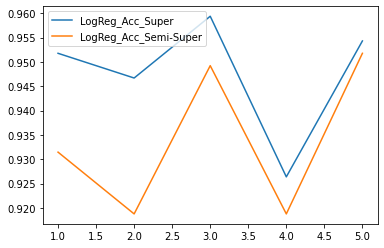

In [78]:


plt.plot(range(1,6), [(accuracy_tab[0][0]),
                     (accuracy_tab[1][0]),
                     (accuracy_tab[2][0]),
                     (accuracy_tab[3][0]),
                     (accuracy_tab[4][0])], label = 'LogReg_Acc_Super')
plt.plot(range(1,6), [(accuracy_tab[0][2]),
                     (accuracy_tab[1][2]),
                     (accuracy_tab[2][2]),
                     (accuracy_tab[3][2]),
                     (accuracy_tab[4][2])], label = 'LogReg_Acc_Semi-Super')
plt.legend()


